# Cooperative optimization for data science - Part II

## Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import math

In [2]:
with open('second_database.pkl', 'rb') as f:
    X, Y = pickle.load(f)

Text(0.5, 1.0, 'Data visualization')

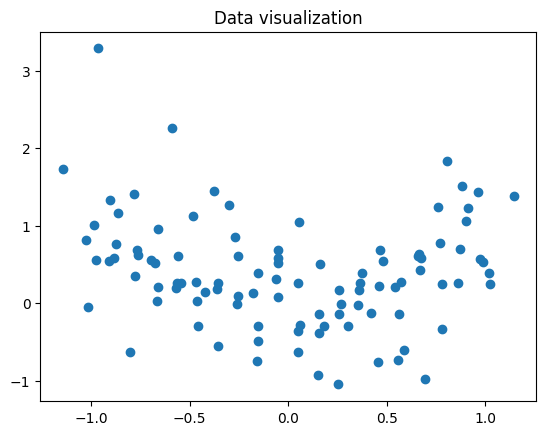

In [3]:
plt.scatter(X, Y)
plt.title("Data visualization")

In [4]:
n = 100
m = 10
a = 5

sigma = 0.5
nu = 1

In [5]:
x_m_points=np.linspace(-1,1,m)

x_m_points

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

## F(alpha)

In [6]:
def K(Xn, Xm):
    K = [[np.exp(-np.linalg.norm(xi - xj)**2) for xj in Xm] for xi in Xn]
    return np.array(K)

In [7]:
Kmm = K(x_m_points,x_m_points)

$$ \nabla f_j (\alpha) = \frac{\sigma^2}{5} K_{mm} \alpha + \sum_{j \in B_j} (-K^T_{(j)m}) (y_j - K_{(j)m}\alpha) + \frac{\nu}{5} \alpha $$

In [8]:
def grad_f(i, Bj, alpha):
    global x_m_points, Kmm, sigma, nu
    
    res =  (sigma**2/5) * Kmm @ alpha
    for j in Bj:
        Kjm = K([X[i][j]], x_m_points)
        res += (-Kjm.T) @ (Y[i][j] - Kjm @ alpha)
    res +=  nu/5 * alpha
    return res

$$ f_i (\alpha) = \frac{\sigma^2}{5} \frac{1}{2} \alpha^T K_{mm} \alpha + \frac{1}{2} \sum_{j \in A} || y_j - K_{(j)m}\alpha ||^2_2 + \frac{\nu}{10} || \alpha||^2_2 $$

In [9]:
def f(i, alpha):
    global x_m_points, Kmm, sigma, nu, X, Y
    
    res = (sigma**2 / 5) * (1/2) * alpha.T @ Kmm @ alpha
    for j in range(len(X[i])):
        Kjm = K([X[i][j]], x_m_points)
        res += (1/2) * np.linalg.norm(Y[i][j] - Kjm @ alpha)**2 
    res += nu/10 * np.linalg.norm(alpha)**2
    return res

In [10]:
def F(alpha):
    
    F = 0
    for i in range(a):
        F += f(i,alpha)
        
    return F

## alpha*

In [11]:
from scipy.optimize import minimize

In [12]:
alpha0 = np.zeros(m)

res = minimize(F, alpha0)
alpha_star = res.x

alpha_star

array([ 0.62445432,  0.45908724,  0.21136555, -0.07285091, -0.31601167,
       -0.42589489, -0.33441328, -0.04036389,  0.37500539,  0.77795709])

In [13]:
F_star = F(alpha_star)

F_star

20.043662799369717

## FedAvg

In [14]:
def client_update(B, i, E, alpha0):
    global X
    
    sel = [i for i in range(len(X[i]))]
    ind = np.random.choice(sel, B, replace=False)
    Bj = [j for j in ind]
    
    alpha_new = alpha0
    # for each epoch
    for k in range(E):
        alpha = alpha_new
        alpha_new = alpha - learning_rate(k) * grad_f(i, Bj, alpha)
        
    return alpha_new

In [15]:

def FedAvg(B, C, epochs, num_iterations):
    global m

    alpha0 = np.zeros(m)

    optimality_gap_tracking = np.zeros((len(epochs),num_iterations))

    for e in range(len(epochs)): 
        alpha_new = alpha0
        for t in range(num_iterations):
            alpha = alpha_new
            alpha_new = np.zeros(m)

            # for each client
            for c in range(C):
                alpha_c = client_update(B, c, epochs[e], alpha)

                # All clients have the same number of points, then Nc/sum(N) = 1/C
                alpha_new += 1/C * alpha_c
                
            optimality_gap_tracking[e,t] = F(alpha_new) - F_star
    
    return optimality_gap_tracking
    

In [16]:
# Visualize the results
# Plot the optimality gap

def plot_opt_gap(optimality_gap_tracking, B, C, epochs, num_iterations, learning_rate):
    plt.figure()
    for e in range(len(epochs)):
        # Plot the optimality gap for the current epoch
        plt.loglog(np.arange(1, num_iterations + 1), optimality_gap_tracking[e], label=f'E = {epochs[e]}')
    plt.xlabel('Iterations')
    plt.ylabel('Objective Optimality Gap F($\\alpha$) - F($\\alpha*$)')
    plt.title(f'Optimality Gap vs. Iterations with FedAvg B={B}, C={C}, learning rate={learning_rate}')
    plt.grid(True)
    plt.legend()
    plt.ylim(1e-6, 20)
    plt.show()

In [17]:
# Parameters

B = 20
C = 5
epochs = [1, 5, 50]

num_iterations = 10000

def learning_rate(k):
    return 0.002

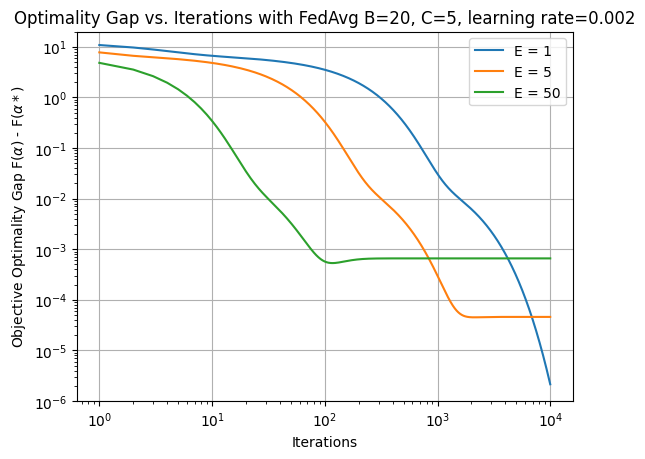

In [18]:
optimality_gap_tracking = FedAvg(B, C, epochs, num_iterations)
plot_opt_gap(optimality_gap_tracking, B, C, epochs, num_iterations, learning_rate(1))

## Diferent parameters

### Diminishing learning rate

In [19]:
B = 20
C = 5
epochs = [1, 5, 50]

num_iterations = 10000

def learning_rate(k):
    return 0.002/(0.01*k + 1)

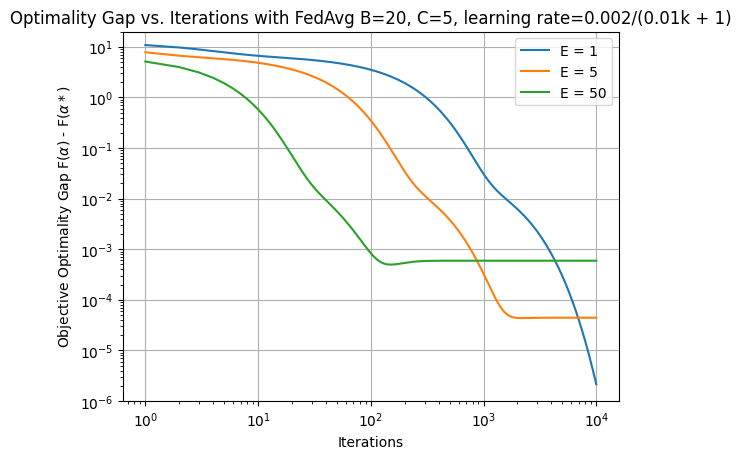

In [20]:
optimality_gap_tracking2 = FedAvg(B, C, epochs, num_iterations)
plot_opt_gap(optimality_gap_tracking2, B, C, epochs, num_iterations, "0.002/(0.01k + 1)")

### B=15

In [25]:
B = 15
C = 5
epochs = [1, 5, 50]

num_iterations = 10000

def learning_rate(k):
    return 0.002

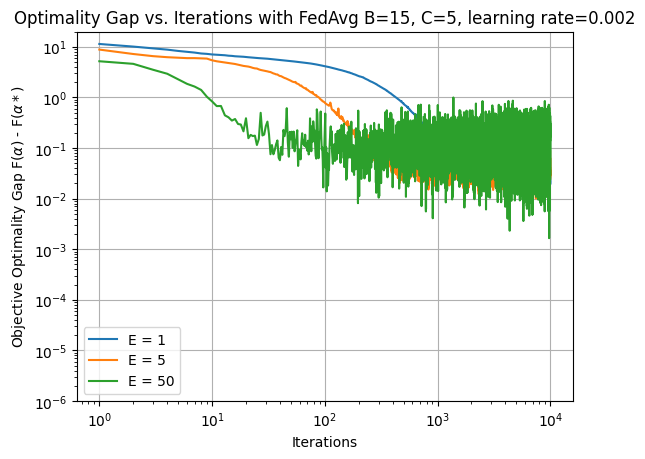

In [26]:
optimality_gap_tracking3 = FedAvg(B, C, epochs, num_iterations)
plot_opt_gap(optimality_gap_tracking3, B, C, epochs, num_iterations, learning_rate(1))

### B=15 and C=3

In [23]:
B = 15
C = 3
epochs = [1, 5, 50]

num_iterations = 10000

def learning_rate(k):
    return 0.002

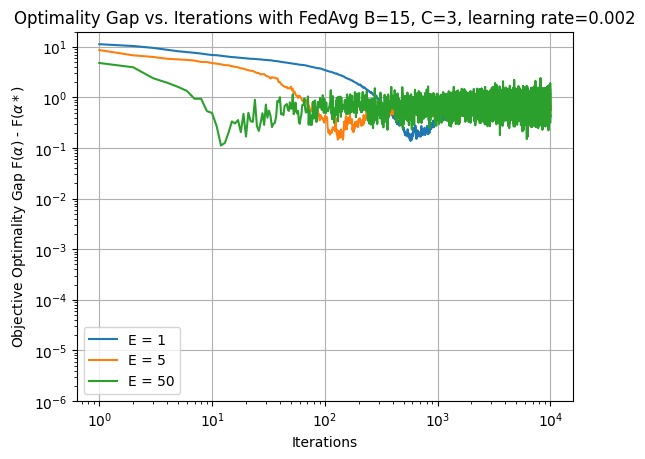

In [24]:
optimality_gap_tracking4 = FedAvg(B, C, epochs, num_iterations)
plot_opt_gap(optimality_gap_tracking4, B, C, epochs, num_iterations, learning_rate(1))